Diego Toribio <br>
Professor Sam Keene <br>
Frequentist Machine Learning <br>
Project 2: Logistic Regression



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(13)

### Heart Disease Dataset

In [ ]:
!wget -O dataset https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data

--2024-12-20 20:24:30--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data [following]
--2024-12-20 20:24:30--  https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data
Resolving hastie.su.domains (hastie.su.domains)... 146.190.148.141
Connecting to hastie.su.domains (hastie.su.domains)|146.190.148.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25106 (25K)
Saving to: ‘dataset’

dataset             100%[===================>]  24.52K  --.-KB/s    in 0.02s   

2024-12-20 20:24:30 (1.49 MB/s) - ‘dataset’ saved [25106/25106]



In [ ]:
df = pd.read_csv('dataset', index_col=0)

df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})
df.insert(0, 'intercept', 1)

print(tabulate(df.head(), headers='keys', tablefmt='pretty'))
print(df.shape)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

feature_names = df.columns[:-1].tolist()

+-----------+-----------+-------+---------+------+-----------+---------+-------+---------+---------+------+-----+
| row.names | intercept |  sbp  | tobacco | ldl  | adiposity | famhist | typea | obesity | alcohol | age  | chd |
+-----------+-----------+-------+---------+------+-----------+---------+-------+---------+---------+------+-----+
|     1     |    1.0    | 160.0 |  12.0   | 5.73 |   23.11   |   1.0   | 49.0  |  25.3   |  97.2   | 52.0 | 1.0 |
|     2     |    1.0    | 144.0 |  0.01   | 4.41 |   28.61   |   0.0   | 55.0  |  28.87  |  2.06   | 63.0 | 1.0 |
|     3     |    1.0    | 118.0 |  0.08   | 3.48 |   32.28   |   1.0   | 52.0  |  29.14  |  3.81   | 46.0 | 0.0 |
|     4     |    1.0    | 170.0 |   7.5   | 6.41 |   38.03   |   1.0   | 51.0  |  31.99  |  24.26  | 58.0 | 1.0 |
|     5     |    1.0    | 134.0 |  13.6   | 3.5  |   27.78   |   1.0   | 60.0  |  25.99  |  57.34  | 49.0 | 1.0 |
+-----------+-----------+-------+---------+------+-----------+---------+-------+--------

#### (i) Figure 4.12

Replicate the analysis of the South African heart disease dataset from the Elements of Statistical Learning textbook and plot figure 4.12. *italicized text*

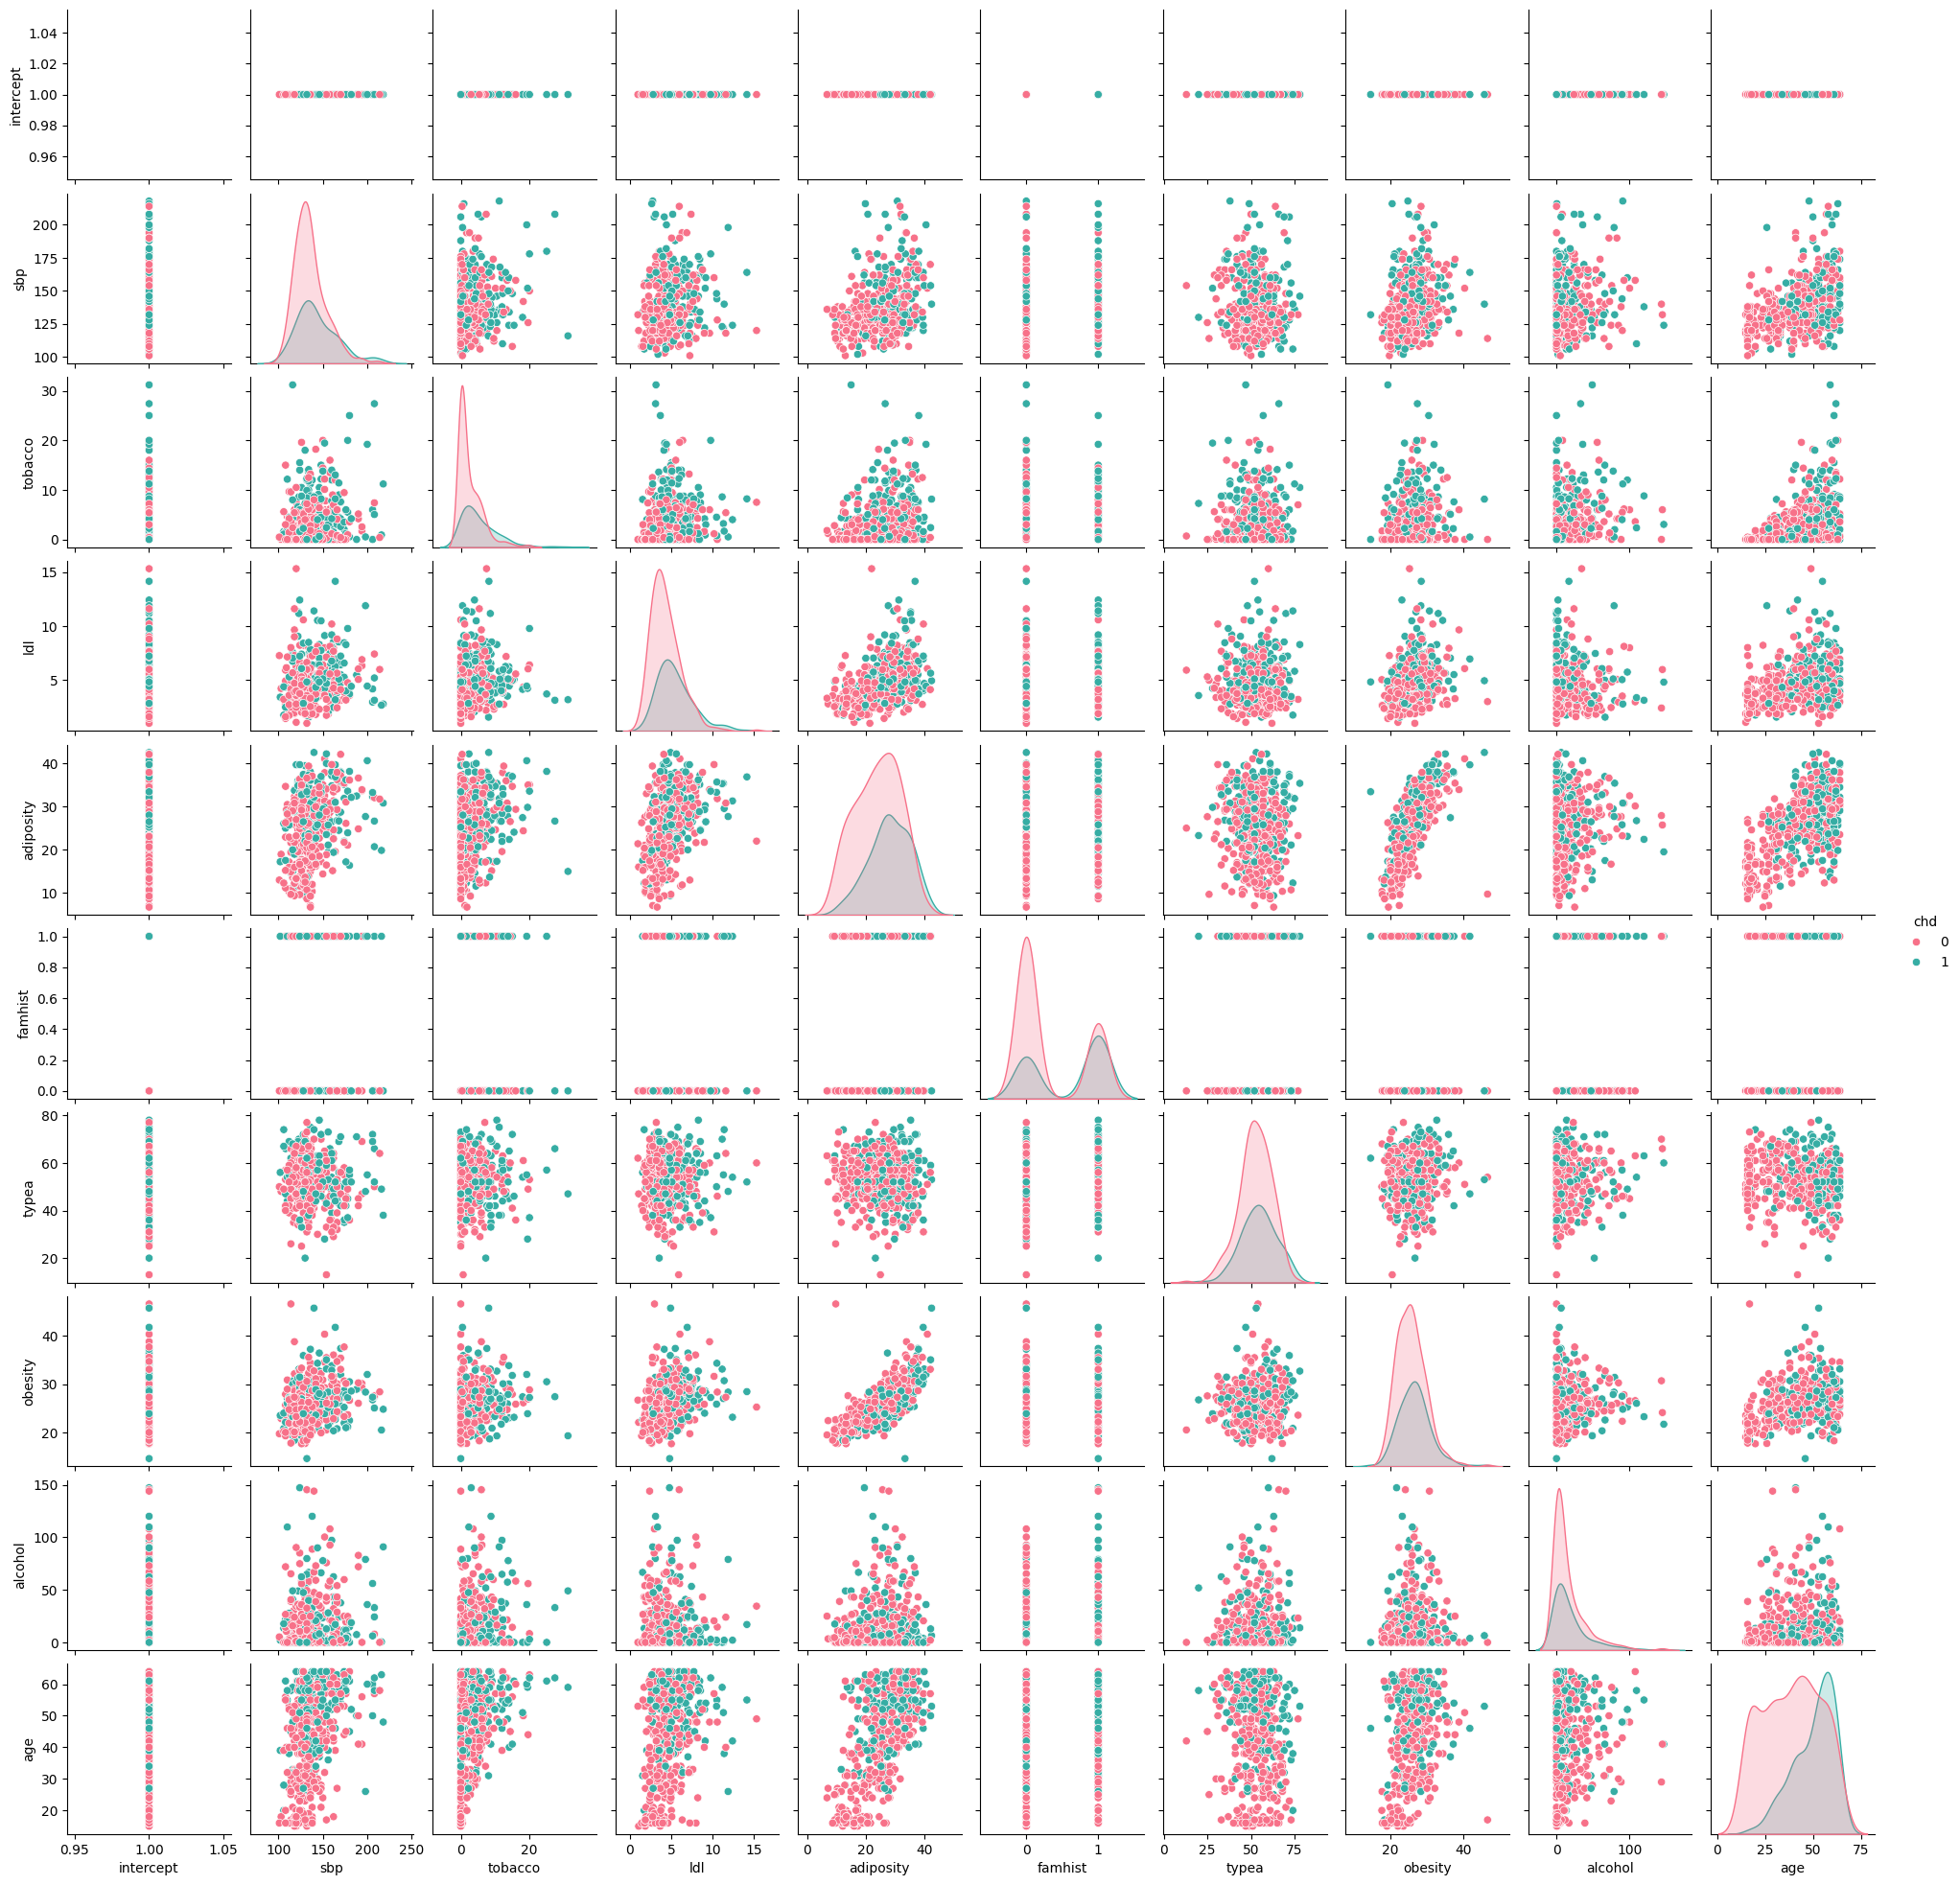

In [ ]:
sns.pairplot(df, hue = 'chd', palette="husl", height = 2)

#### On Prep Processing

Normalizing the features using the maximum absolute value.

- Calculating the maximum absolute value of each feature
- Applies the maximum absolute value to the train, val and test

In [ ]:
def split(X, Y, val_size, random_state=13):

    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=val_size, random_state=random_state)

    return X_train, X_val, Y_train, Y_val

In [ ]:
val_size = 0.20
random_state = 13

X_train, X_val, Y_train, Y_val = split(X, Y, val_size, random_state)
print('Training Samples:', len(X_train))
print('Validation Samples:', len(X_val))

Training Samples: 369
Validation Samples: 93


In [ ]:
def normalize(X_train, X_val, Y_train, Y_val):
    feature_scaler = preprocessing.MaxAbsScaler().fit(X_train)
    X_train_scaled = feature_scaler.transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)

    target_scaler = preprocessing.MaxAbsScaler().fit(Y_train.reshape(-1, 1))
    y_train_scaled = target_scaler.transform(Y_train.reshape(-1, 1)).reshape(-1)
    y_val_scaled = target_scaler.transform(Y_val.reshape(-1, 1)).reshape(-1)

    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled

In [ ]:
X_train, X_val, Y_train, Y_val = normalize(X_train, X_val, Y_train, Y_val)

### On Implementation

**Sigmoid Function:**  
The sigmoid function maps the input $ z $ (a linear combination of weights and features) to a probability between 0 and 1:  
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Stochastic Gradient Descent (SGD):**  
SGD updates weights $w_i $ iteratively using the gradient of the loss function:  
$$
w_i = w_i - \eta \left(\frac{\partial L(j, w)}{\partial w_i}\right)
$$  
where $ \eta $ is the learning rate.

---

**SGD with L1 Regularization (Cumulative Penalty Method):**  
We implemented L1 regularization using the cumulative penalty method from Tsuruoka et al., ensuring smooth and stable weight updates.

**Key Steps:**
1. **Gradient Update:** Compute the initial weight update:
   $$
   w_i^{k+\frac{1}{2}} = w_i^k - \eta_k \left(\frac{\partial L(j, w)}{\partial w_i}\right)
   $$

2. **Apply Cumulative Penalty:** Adjust weights using global ($ u $) and weight-specific ($ q[i] $) penalties:
   - If \( w_i^{k+\frac{1}{2}} > 0 \):  
     $$
     w_i^{k+1} = \max(0, w_i^{k+\frac{1}{2}} - (u + q[i]))
     $$
   - If \( w_i^{k+\frac{1}{2}} < 0 \):  
     $$
     w_i^{k+1} = \min(0, w_i^{k+\frac{1}{2}} + (u - q[i]))
     $$

3. **Update $ q[i] $:** Track changes in weights:
   $$
   q[i] += w_i^{k+1} - w_i^k
   $$

4. **Increment $ u $:** Increase the global cumulative penalty:
   $$
   u = u + \frac{\eta_k C}{N}
   $$

---

### Notation:
- $ w_i^{k+\frac{1}{2}} $: Weight after gradient update, before penalty.
- $ w_i^{k+1} $: Final weight after penalty.
- $ \eta_k $: Learning rate at iteration $ k $.
- $ u $: Global cumulative penalty.
- $ q[i] $: Penalty specific to weight $ w_i $.
- $ C $: Regularization strength.
- $ N $: Number of training samples.



In [ ]:
import numpy as np

class LogisticRegression:
    def __init__(
        self, epochs, alpha, input_dim, lambda_reg=0.01, batch_size=None, penalty=None
    ):
        self.epochs = epochs
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.penalty = penalty
        self.batch_size = batch_size
        # Weight initialization
        self.beta = np.random.randn(input_dim) * np.sqrt(2.0 / input_dim)
        # Will be initialized in fit once we know training size:
        self.u = 0.0
        self.q = None
        self.N = None

    @staticmethod
    def sigmoid(z):
        return np.clip(1 / (1 + np.exp(-z)), 1e-8, 1 - 1e-8)

    def predict(self, X):
        z = X @ self.beta
        return self.sigmoid(z)

    def loss(self, X, Y, Y_hat):
        loss = -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
        if self.penalty == "L2":
            loss += 0.5 * self.lambda_reg * np.sum(self.beta[1:] ** 2)
        elif self.penalty == "L1":
            # L1 regularization: sum of absolute values
            loss += self.lambda_reg * np.sum(np.abs(self.beta[1:]))
        return loss

    def update(self, X, Y, Y_hat):
        # Compute gradient
        e = Y_hat - Y
        gradient = X.T @ e / X.shape[0]

        # L2 penalty gradient
        if self.penalty == "L2":
            gradient[1:] += self.lambda_reg * self.beta[1:]

        # Gradient step
        self.beta -= self.alpha * gradient

        # If L1 penalty, apply cumulative penalty method
        if self.penalty == "L1":
            # Increase cumulative penalty
            self.u += (self.alpha * self.lambda_reg) / self.N

            # Apply cumulative L1 penalty to each weight (except intercept)
            for i in range(1, len(self.beta)):
                z = self.beta[i]
                if self.beta[i] > 0:
                    self.beta[i] = max(0, self.beta[i] - (self.u + self.q[i]))
                elif self.beta[i] < 0:
                    self.beta[i] = min(0, self.beta[i] + (self.u - self.q[i]))
                self.q[i] += self.beta[i] - z

    def fit(self, X_train, Y_train, X_val=None, Y_val=None):
        self.N = X_train.shape[0]
        if self.batch_size is None:
            self.batch_size = self.N

        # Initialize cumulative penalty arrays for L1 if needed
        if self.penalty == "L1":
            self.u = 0.0
            self.q = np.zeros_like(self.beta)

        indices = np.arange(self.N)
        training_losses = []
        training_accuracies = []
        validation_losses = []
        validation_accuracies = []

        for epoch in range(self.epochs):
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            Y_train_shuffled = Y_train[indices]

            for start_idx in range(0, self.N, self.batch_size):
                end_idx = min(start_idx + self.batch_size, self.N)
                X_batch = X_train_shuffled[start_idx:end_idx]
                Y_batch = Y_train_shuffled[start_idx:end_idx]
                Y_hat = self.predict(X_batch)
                self.update(X_batch, Y_batch, Y_hat)
                train_loss = self.loss(X_batch, Y_batch, Y_hat)
                training_losses.append(train_loss)

            train_accuracy = self.score(X_train, Y_train)
            training_accuracies.append(train_accuracy)

            if X_val is not None and Y_val is not None:
                Y_val_hat = self.predict(X_val)
                val_loss = self.loss(X_val, Y_val, Y_val_hat)
                val_accuracy = self.score(X_val, Y_val)
                validation_losses.append(val_loss)
                validation_accuracies.append(val_accuracy)

        return (
            training_losses,
            training_accuracies,
            validation_losses,
            validation_accuracies,
        )

    def score(self, X, Y):
        Y_hat = self.predict(X)
        predictions = (Y_hat >= 0.5).astype(int)
        return np.mean(predictions == Y)


In [ ]:
def find_best_lambda(X_train, Y_train, X_val, Y_val, lambd_vals, epochs, alpha, input_dim, batch_size=None):
    best_lambda = None
    best_accuracy = 0

    for lambd in lambd_vals:
        model = LogisticRegression(epochs=epochs, alpha=alpha, lambda_reg=lambd, input_dim=input_dim, batch_size=batch_size, penalty='L2')
        _, _, _, val_accs = model.fit(X_train, Y_train, X_val, Y_val)

        current_accuracy = np.mean(val_accs[-10:])

        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_lambda = lambd

    return best_lambda

#### (ii) Comparing Results

Report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table.

In [ ]:
alpha = 0.05
epochs = 10000
input_dim = X_train.shape[1]
batch_size = 20

# Unregularized model
m1 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim)
train_losses_m1, unreg_train_accs, val_losses_m1, unreg_val_accs = m1.fit(X_train, Y_train, X_val, Y_val)

# Step-Wise
m2 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim, batch_size=batch_size)
train_losses_m2, step_train_accs, val_losses_m2, step_val_accs = m2.fit(X_train, Y_train, X_val, Y_val)

# L2 Regularization
lambd_vals = np.logspace(-6, 1, 10)
best_lambda = find_best_lambda(X_train, Y_train, X_val, Y_val, lambd_vals, epochs, alpha, input_dim, batch_size)
m3 = LogisticRegression(epochs=epochs, alpha=alpha, lambda_reg=best_lambda, input_dim=input_dim, penalty='L2')
train_losses_m3, l2_train_accs, val_losses_m3, l2_val_accs = m3.fit(X_train, Y_train, X_val, Y_val)

# L1 Regularization
m4 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim, penalty='L1')
train_losses_m4, l1_train_accs, val_losses_m4, l1_val_accs = m4.fit(X_train, Y_train, X_val, Y_val)


In [ ]:

results = [
    ["Unregularized", f"{unreg_train_accs[-1] * 100:.2f}%", f"{unreg_val_accs[-1] * 100:.2f}%"],
    ["Step-Wise (SGD)", f"{step_train_accs[-1] * 100:.2f}%", f"{step_val_accs[-1] * 100:.2f}%"],
    ["L2 Regularization", f"{l2_train_accs[-1] * 100:.2f}%", f"{l2_val_accs[-1] * 100:.2f}%"],
    ["L1 Regularization", f"{l1_train_accs[-1] * 100:.2f}%", f"{l1_val_accs[-1] * 100:.2f}%"]
]
headers = ["Model Type", "Training Accuracy", "Validation Accuracy"]

print(tabulate(results, headers=headers, tablefmt="pretty"))


+-------------------+-------------------+---------------------+
|    Model Type     | Training Accuracy | Validation Accuracy |
+-------------------+-------------------+---------------------+
|   Unregularized   |      74.53%       |       68.82%        |
|  Step-Wise (SGD)  |      75.34%       |       65.59%        |
| L2 Regularization |      75.07%       |       68.82%        |
| L1 Regularization |      75.07%       |       68.82%        |
+-------------------+-------------------+---------------------+


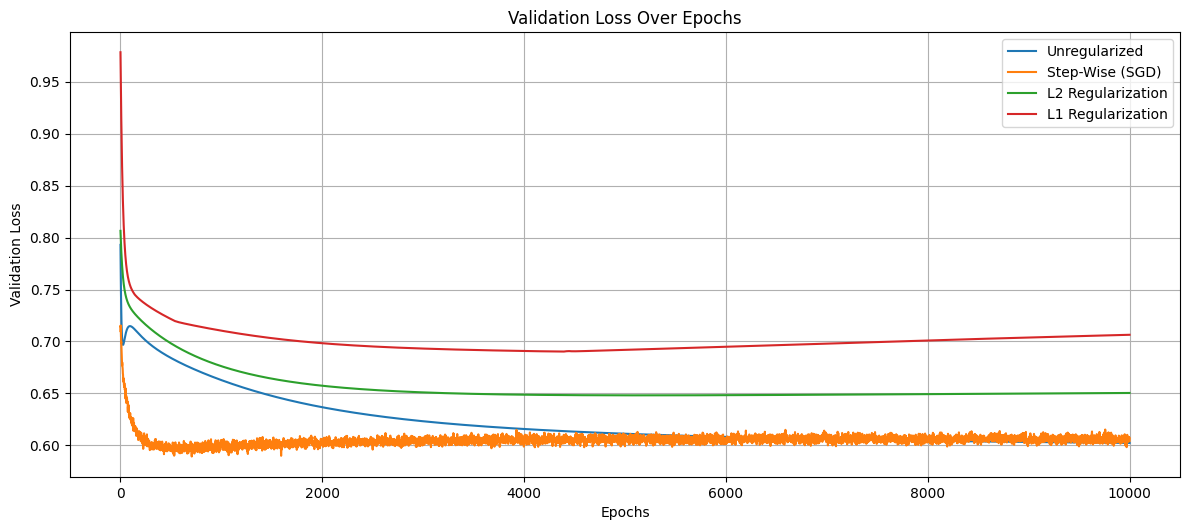

In [ ]:
plt.figure(figsize=(12, 10))

# Subplot for Validation Loss
plt.subplot(2, 1, 2)
plt.plot(val_losses_m1, label='Unregularized')
plt.plot(val_losses_m2, label='Step-Wise (SGD)')
plt.plot(val_losses_m3, label='L2 Regularization')
plt.plot(val_losses_m4, label='L1 Regularization')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### (iii) Cross Validation

Select the optimal model using forward stepwise via cross-validation and report which features are the most important.

In [ ]:
def forward_stepwise_selection(X_train, Y_train, X_val, Y_val, feature_names):
    remaining_features = [f for f in feature_names if f != 'intercept']
    selected_features = []
    best_overall_accuracy = 0

    while remaining_features:
        best_feature_this_round = None
        best_accuracy_this_round = 0

        for feature in remaining_features:
            current_features = selected_features + [feature]
            current_feature_indices = [feature_names.index(f) for f in current_features]
            X_train_sub = X_train[:, current_feature_indices]
            X_val_sub = X_val[:, current_feature_indices]

            model = LogisticRegression(epochs=10000, alpha=0.05, input_dim=len(current_features))
            _, train_accs, _, val_accs = model.fit(X_train_sub, Y_train, X_val_sub, Y_val)
            current_val_accuracy = np.mean(val_accs[-10:])

            if current_val_accuracy > best_accuracy_this_round:
                best_accuracy_this_round = current_val_accuracy
                best_feature_this_round = feature

        if best_feature_this_round and best_accuracy_this_round > best_overall_accuracy:
            best_overall_accuracy = best_accuracy_this_round
            selected_features.append(best_feature_this_round)
            remaining_features.remove(best_feature_this_round)
        else:
            break

    return selected_features, best_overall_accuracy

In [ ]:
selected_features, best_accuracy = forward_stepwise_selection(X_train, Y_train, X_val, Y_val, feature_names)
print("Selected features:", selected_features)
print(f"Best validation accuracy achieved: {best_accuracy * 100:.2f}%")

Selected features: ['sbp', 'tobacco', 'age', 'ldl', 'adiposity']
Best validation accuracy achieved: 70.97%


#### (iv) Different Dataset

Repeat this analysis for a binary classification dataset of your choice from UCI or another repository.

In [ ]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
data = read_csv(url, header=None)
data.insert(0, 'intercept', 1)

# Display the first few rows of the DataFrame
print(tabulate(data.head(), headers='keys', tablefmt='pretty'))
print(data.shape)

# Split data into input (X) and output (y)
X, Y = data.values[:, :-1], data.values[:, -1]

feature_names = data.columns[:-1].tolist()
print(feature_names)

+---+-----------+---------+---------+---------+----------+-----+
|   | intercept |    0    |    1    |    2    |    3     |  4  |
+---+-----------+---------+---------+---------+----------+-----+
| 0 |    1.0    | 3.6216  | 8.6661  | -2.8073 | -0.44699 | 0.0 |
| 1 |    1.0    | 4.5459  | 8.1674  | -2.4586 | -1.4621  | 0.0 |
| 2 |    1.0    |  3.866  | -2.6383 | 1.9242  | 0.10645  | 0.0 |
| 3 |    1.0    | 3.4566  | 9.5228  | -4.0112 | -3.5944  | 0.0 |
| 4 |    1.0    | 0.32924 | -4.4552 | 4.5718  | -0.9888  | 0.0 |
+---+-----------+---------+---------+---------+----------+-----+
(1372, 6)
['intercept', 0, 1, 2, 3]


In [ ]:
X_train, X_val, Y_train, Y_val = split(X, Y, val_size, random_state)
print('Training Samples:', len(X_train))
print('Validation Samples:', len(X_val))

Training Samples: 1097
Validation Samples: 275


In [ ]:
X_train, X_val, Y_train, Y_val = normalize(X_train, X_val, Y_train, Y_val)

In [ ]:
alpha = 0.05
epochs = 3000
input_dim = X_train.shape[1]
batch_size = 20

# Unregularized model
m1 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim)
train_losses_m1, unreg_train_accs, val_losses_m1, unreg_val_accs = m1.fit(X_train, Y_train, X_val, Y_val)

# Step-Wise
m2 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim, batch_size=batch_size)
train_losses_m2, step_train_accs, val_losses_m2, step_val_accs = m2.fit(X_train, Y_train, X_val, Y_val)

# L2 Regularization
lambd_vals = np.logspace(-6, 1, 10)
best_lambda = find_best_lambda(X_train, Y_train, X_val, Y_val, lambd_vals, epochs, alpha, input_dim, batch_size)
m3 = LogisticRegression(epochs=epochs, alpha=alpha, lambda_reg=best_lambda, input_dim=input_dim, penalty='L2')
train_losses_m3, l2_train_accs, val_losses_m3, l2_val_accs = m3.fit(X_train, Y_train, X_val, Y_val)

# L1 Regularization
m4 = LogisticRegression(epochs=epochs, alpha=alpha, input_dim=input_dim, penalty='L1')
train_losses_m4, l1_train_accs, val_losses_m4, l1_val_accs = m4.fit(X_train, Y_train, X_val, Y_val)


In [ ]:
results = [
    ["Unregularized", f"{unreg_train_accs[-1] * 100:.2f}%", f"{unreg_val_accs[-1] * 100:.2f}%"],
    ["Step-Wise (SGD)", f"{step_train_accs[-1] * 100:.2f}%", f"{step_val_accs[-1] * 100:.2f}%"],
    ["L2 Regularization", f"{l2_train_accs[-1] * 100:.2f}%", f"{l2_val_accs[-1] * 100:.2f}%"],
    ["L1 Regularization", f"{l1_train_accs[-1] * 100:.2f}%", f"{l1_val_accs[-1] * 100:.2f}%"]
]
headers = ["Model Type", "Training Accuracy", "Validation Accuracy"]

print(tabulate(results, headers=headers, tablefmt="pretty"))

+-------------------+-------------------+---------------------+
|    Model Type     | Training Accuracy | Validation Accuracy |
+-------------------+-------------------+---------------------+
|   Unregularized   |      92.16%       |       94.18%        |
|  Step-Wise (SGD)  |      98.63%       |       97.82%        |
| L2 Regularization |      92.80%       |       93.45%        |
| L1 Regularization |      92.34%       |       94.55%        |
+-------------------+-------------------+---------------------+


### Stretch Goal #2

#### Multinomial Logistic Regression: Implementation and Explanation

We extended binary logistic regression to multinomial logistic regression for multi-class classification, using the gradient of the cross-entropy loss from Bishop’s equation (4.109).

---

### Implementation

1. **Softmax Function:**  
   Converts logits $ Z $ into probabilities for $ K $ classes:  
   $$
   \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
   $$

2. **Cross-Entropy Loss:**  
   Optimized the following loss function for multi-class classification:  
   $$
   L = - \sum_{n=1}^N \sum_{j=1}^K t_{nj} \log(y_{nj})
   $$  
   where $ t_{nj} $ is the one-hot encoded target, $ y_{nj} $ is the predicted probability, and $ N $ is the number of samples.

3. **Gradient of Loss (Equation 4.109):**  
   Used the gradient of the loss for weight updates:  
   $$
   \nabla_W = X^T (Y - T)
   $$  
   where:
   - $ X $: Feature matrix ($ N \times D $),
   - $ Y $: Predicted probabilities ($ N \times K $),
   - $ T $: One-hot encoded targets ($ N \times K $),
   - $ W $: Weight matrix ($ D+1 \times K $).

4. **Steps in Training:**  
   - Added a bias term to $ X $.  
   - Initialized $ W $ as zeros.  
   - Used softmax to compute class probabilities.  
   - Applied gradient descent:  
     $$
     W = W - \eta \nabla_W
     $$  
     where $ \eta $ is the learning rate.

5. **Prediction:**  
   Predicted the class with the highest probability for each sample.

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W = None

    def _add_bias(self, X):
        N = X.shape[0]
        return np.hstack([np.ones((N, 1)), X])

    def _softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def fit(self, X, T):
        X = self._add_bias(X)
        N, Dplus1 = X.shape
        K = T.shape[1]

        # Initialize weights
        self.W = np.zeros((Dplus1, K))

        for _ in range(self.epochs):
            Z = X @ self.W
            Y = self._softmax(Z)

            # Gradient of cross-entropy (equation 4.109):
            # ∇_wj E = Σ_n (y_nj - t_nj) φ_n
            grad = X.T @ (Y - T)

            # Update weights
            self.W -= self.learning_rate * grad

    def predict_proba(self, X):
        X = self._add_bias(X)
        Z = X @ self.W
        return self._softmax(Z)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

In [ ]:
# Load iris data
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encode targets
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(y.reshape(-1, 1))

# Train/validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train
model = MultinomialLogisticRegression(learning_rate=0.05, epochs=1000)
model.fit(X_train, Y_train)

# Evaluate on validation set
preds = model.predict(X_val)
val_labels = np.argmax(Y_val, axis=1)

accuracy = np.mean(preds == val_labels)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9666666666666667
